# Importing libraries

In [7]:
# Importing the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Data preparation

In [8]:
# Reading the data
df = pd.read_csv("tweets.csv", sep=",")
# Dropping the unnecessary features
df.drop(["selected_text", "textID"], axis=1, inplace=True)
# Dropping the rows with missing values
df.dropna(inplace=True)
# Dropping the rows with neutral sentiment
df = df[df["sentiment"] != "neutral"]
# Converting the sentiment to binary
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

df.head()

,text,sentiment
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
6,2am feedings for the baby are fun when he is a...,1


# Splitting data

In [9]:
# Splitting the data to train and test
texts = df['text']  
labels = df['sentiment']  
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Vectorizing the text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Applying models
## Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB

# Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_nb = nb_model.predict(X_test_vec)
nb_classification_report = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

Naive Bayes:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      1603
           1       0.84      0.89      0.87      1670

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
weighted avg       0.86      0.86      0.86      3273



## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

# Training the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
lr_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_lr = lr_model.predict(X_test_vec)
lr_classification_report = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
print("Logistic regression:\n", classification_report(y_test, y_pred_lr))

Logistic regression:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1603
           1       0.88      0.88      0.88      1670

    accuracy                           0.88      3273
   macro avg       0.88      0.88      0.88      3273
weighted avg       0.88      0.88      0.88      3273



## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_rf = rf_model.predict(X_test_vec)
rf_clasification_report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1603
           1       0.88      0.83      0.86      1670

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
weighted avg       0.86      0.86      0.86      3273



## SVC

In [13]:
from sklearn.svm import SVC

# Training the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_svm = svm_model.predict(X_test_vec)
svm_classification_report = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
print("SVM:\n", classification_report(y_test, y_pred_svm))

SVM:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      1603
           1       0.88      0.88      0.88      1670

    accuracy                           0.88      3273
   macro avg       0.88      0.88      0.88      3273
weighted avg       0.88      0.88      0.88      3273



## Bert

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

# Initializing the tokenizer and the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
y_pred_bert = []
# This function calculates the roberta sentiment scores and returns them as a dictionary
def polarity_scores(text):
    text = text[:512]
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    if scores[0] > scores[2]:
        y_pred_bert.append(0)
    else:    
        y_pred_bert.append(1)

In [16]:
X_test.apply(polarity_scores)
bert_classification_report = classification_report(y_test, y_pred_bert, output_dict=True, zero_division=0)
print("BERT:\n", classification_report(y_test, y_pred_bert))

BERT:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      1603
           1       0.91      0.94      0.92      1670

    accuracy                           0.92      3273
   macro avg       0.92      0.92      0.92      3273
weighted avg       0.92      0.92      0.92      3273



# Comparing results
## Precision-Recall Curve

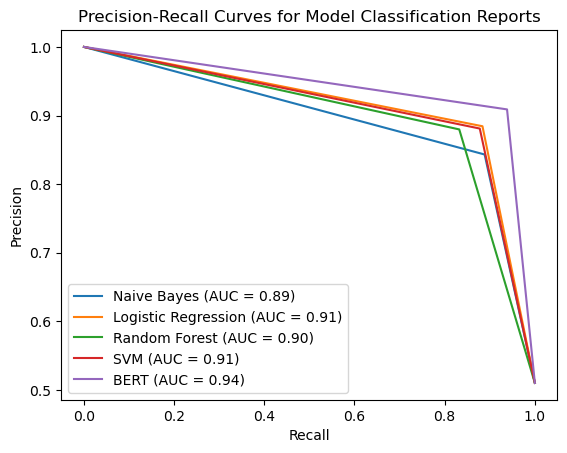

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate the precision-recall curves for each model
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_pred_nb)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)
precision_bert, recall_bert, _ = precision_recall_curve(y_test, y_pred_bert)

# Calculate the area under the precision-recall curve for each model
auc_nb = auc(recall_nb, precision_nb)
auc_lr = auc(recall_lr, precision_lr)
auc_rf = auc(recall_rf, precision_rf)
auc_svm = auc(recall_svm, precision_svm)
auc_bert = auc(recall_bert, precision_bert)

# Plot the precision-recall curves
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(recall_svm, precision_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(recall_bert, precision_bert, label=f'BERT (AUC = {auc_bert:.2f})')

# Set the plot labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Model Classification Reports')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## ROC Curve

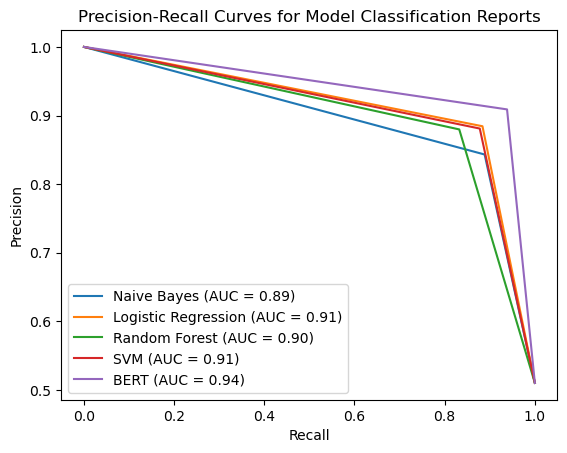

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate the precision-recall curves for each model
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_pred_nb)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)
precision_bert, recall_bert, _ = precision_recall_curve(y_test, y_pred_bert)

# Calculate the area under the precision-recall curve for each model
auc_nb = auc(recall_nb, precision_nb)
auc_lr = auc(recall_lr, precision_lr)
auc_rf = auc(recall_rf, precision_rf)
auc_svm = auc(recall_svm, precision_svm)
auc_bert = auc(recall_bert, precision_bert)

# Plot the precision-recall curves
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(recall_svm, precision_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(recall_bert, precision_bert, label=f'BERT (AUC = {auc_bert:.2f})')

# Set the plot labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Model Classification Reports')

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Accuracies

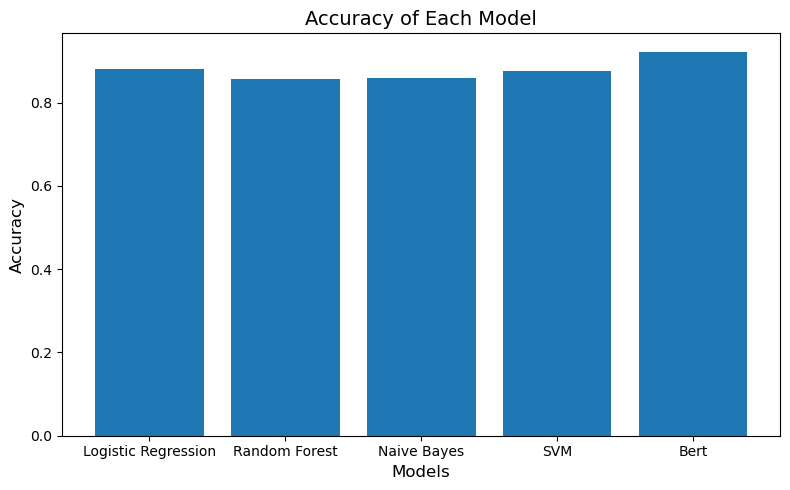

In [19]:
import matplotlib.pyplot as plt

# Example accuracies (use the actual ones you've calculated)
accuracies = {
    "Logistic Regression": lr_classification_report["accuracy"],
    "Random Forest": rf_clasification_report["accuracy"],
    "Naive Bayes": nb_classification_report["accuracy"],
    "SVM": svm_classification_report["accuracy"],
    "Bert": bert_classification_report["accuracy"],
}

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(accuracies.keys(), accuracies.values())

# Customizing the plot
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy of Each Model", fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

In [10]:
from transformers import pipeline

TRUMP_KEYWORDS = ["trump", "donald", "maga"]
BIDEN_KEYWORDS = ["biden", "joe", "buildbackbetter"]

# Initialize the BERT sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


In [7]:
def get_candidate(text: str):
    # Determine candidate attribution
    is_trump = any(keyword.lower() in text.lower() for keyword in TRUMP_KEYWORDS)
    is_biden = any(keyword.lower() in text.lower() for keyword in BIDEN_KEYWORDS)

    if is_trump and not is_biden:
        return "trump"
    elif is_biden and not is_trump:
        return "biden"
    else:
        return "both"

In [23]:
str = 'bad horrible terrible'
print(get_candidate(str))

both


In [24]:
sentiment_result = sentiment_analyzer(str)
print(sentiment_result)


[{'label': 'LABEL_0', 'score': 0.9696105718612671}]


In [26]:
sentiment_analyzer("good happy great")


[{'label': 'LABEL_2', 'score': 0.9758409857749939}]

In [28]:
from transformers import pipeline

# Load sentiment analysis model
sentiment_analyzer = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment", 
    return_all_scores=True  # Get all class probabilities
)

def get_continuous_sentiment(text):
    result = sentiment_analyzer(text)[0]  # Extract class probabilities
    print('reuslt', result)
    # Extract probability scores
    scores = {entry["label"]: entry["score"] for entry in result}

    # Compute weighted sentiment score
    sentiment_score = (
        scores["LABEL_2"] * 1 +   # Positive contributes positively
        scores["LABEL_1"] * 0 +   # Neutral has no effect
        scores["LABEL_0"] * -1    # Negative contributes negatively
    )
    
    return sentiment_score

# Test cases
texts = [
    "Absolutely terrible, I hate it!",
    "It's okay, nothing special.",
    "This is fantastic, I love it!",
    "A bit disappointing but not the worst.",
    "Quite nice, but could be better."
]

# Get scores
for text in texts:
    score = get_continuous_sentiment(text)
    print(f"Text: {text}\nSentiment Score: {score:.2f}\n")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


reuslt [{'label': 'LABEL_0', 'score': 0.9778292179107666}, {'label': 'LABEL_1', 'score': 0.01776224747300148}, {'label': 'LABEL_2', 'score': 0.004408493172377348}]
Text: Absolutely terrible, I hate it!
Sentiment Score: -0.97

reuslt [{'label': 'LABEL_0', 'score': 0.028730221092700958}, {'label': 'LABEL_1', 'score': 0.3760664761066437}, {'label': 'LABEL_2', 'score': 0.5952032804489136}]
Text: It's okay, nothing special.
Sentiment Score: 0.57

reuslt [{'label': 'LABEL_0', 'score': 0.0022757509723305702}, {'label': 'LABEL_1', 'score': 0.00567827932536602}, {'label': 'LABEL_2', 'score': 0.9920459985733032}]
Text: This is fantastic, I love it!
Sentiment Score: 0.99

reuslt [{'label': 'LABEL_0', 'score': 0.7635065317153931}, {'label': 'LABEL_1', 'score': 0.20993897318840027}, {'label': 'LABEL_2', 'score': 0.02655450627207756}]
Text: A bit disappointing but not the worst.
Sentiment Score: -0.74

reuslt [{'label': 'LABEL_0', 'score': 0.056028906255960464}, {'label': 'LABEL_1', 'score': 0.19098

In [33]:
from transformers import pipeline

# Load sentiment analysis model
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    return_all_scores=True  # Get all class probabilities
)

def get_continuous_sentiment(text, neutral_weight=0.2):  
    """
    Computes a sentiment score in the range of -1 to 1, 
    incorporating neutral sentiment influence.
    
    Args:
        text (str): The input text.
        neutral_weight (float): The weight for neutrality (-1 to 1).
    
    Returns:
        float: Sentiment score between -1 and 1.
    """
    result = sentiment_analyzer(text)[0]  # Extract class probabilities
    
    # Extract probability scores
    scores = {entry["label"]: entry["score"] for entry in result}

    # Compute weighted sentiment score including neutral influence
    sentiment_score = (
        scores["LABEL_2"] -
        scores["LABEL_0"] # Negative contributes negatively
    )
    
    return sentiment_score

# Test cases
texts = [
    "Absolutely terrible, I hate it!",
    "It's okay, nothing special.",
    "This is fantastic, I love it!",
    "A bit disappointing but not the worst.",
    "Quite nice, but could be better."
]

# Get scores
for text in texts:
    score = get_continuous_sentiment(text, neutral_weight=0.2)  # Adjust weight as needed
    print(f"Text: {text}\nSentiment Score: {score:.2f}\n")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


Text: Absolutely terrible, I hate it!
Sentiment Score: -0.97

Text: It's okay, nothing special.
Sentiment Score: 0.57

Text: This is fantastic, I love it!
Sentiment Score: 0.99

Text: A bit disappointing but not the worst.
Sentiment Score: -0.74

Text: Quite nice, but could be better.
Sentiment Score: 0.70

